In [2]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 29.9 MB/s eta 0:00:00


In [3]:
# coding=utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, \
    roc_auc_score, roc_curve
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, ZeroPadding2D, MaxPool2D
from keras.regularizers import l2
import visualkeras
import os

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

from collections import defaultdict
import glob

In [4]:
# import the cv2 library
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive/')
workspace = '/content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3'
!ls -la "$workspace"  # "/content/drive/My Drive/Colab Notebooks/AIDI 1006 - Computer Vision/Assign 1"

Mounted at /content/drive/
total 1756
-rw------- 1 root root 926156 Apr  3 19:09 example.ipynb
drwx------ 2 root root   4096 Apr  3 22:04 images
-rw------- 1 root root 754752 Apr  3 23:33 Project3-200520598_Fangji_Chen.ipynb
-rw------- 1 root root 112603 Apr  2 02:56 Project3.pdf


In [6]:
def func(df, gender, label):
    path = workspace + "/images/" + gender + "/*"
    files = glob.glob(path)
    print('file count: %d in workspace %s' % (len(files), path))
    for i, file in enumerate(files):
        img = cv2.imread(file)
        if (i % 100 == 0):
            print("[%d/%d] %d %s" % (i, len(files), label, file))
        df.loc[df.index.size, 'image':'shape'] = [img, label, img.shape[0], img.shape[1], img.shape[2], str(img.shape)]


df = pd.DataFrame(columns=['image', 'label', 'w', 'h', 'c', 'shape'])
func(df, 'femaleeyes', 0)
func(df, 'maleeyes', 1)

file count: 3678 in workspace /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/*
[0/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4481.jpg
[100/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4713.jpg
[200/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4373.jpg
[300/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5146.jpg
[400/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5108.jpg
[500/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4949.jpg
[600/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5257.jpg
[700/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 -

# Display female eyes

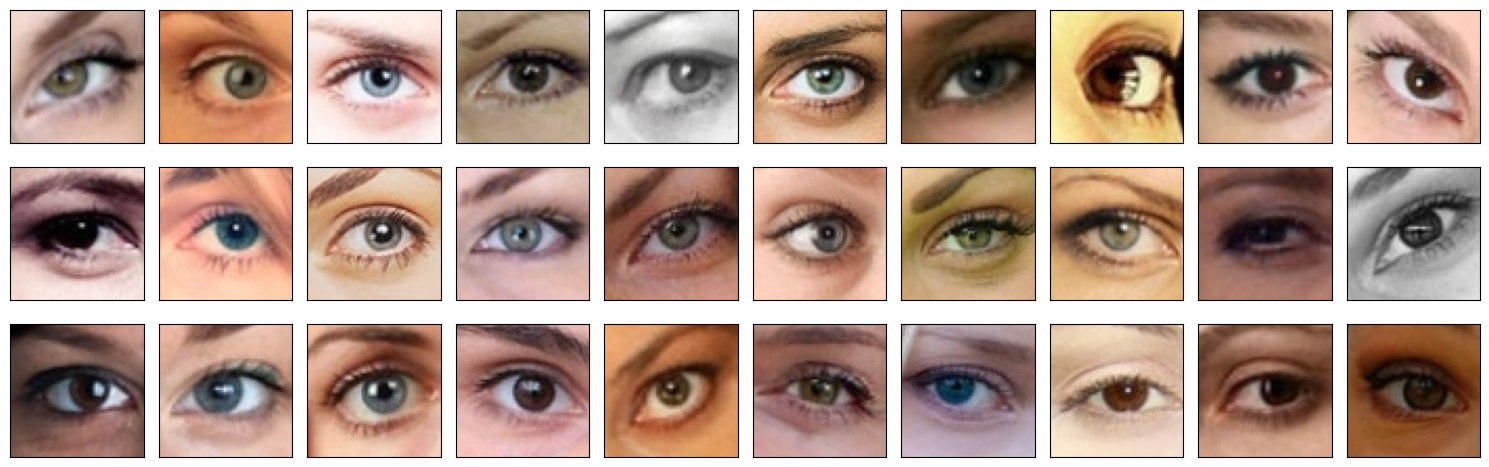

In [221]:
fig, axes = plt.subplots(3, 10, figsize=(15,5), dpi=100)
for i,ax in enumerate(axes.flat):
    img = df[df['label']==0].reset_index(drop=True).loc[i, 'image']
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Display male eyes

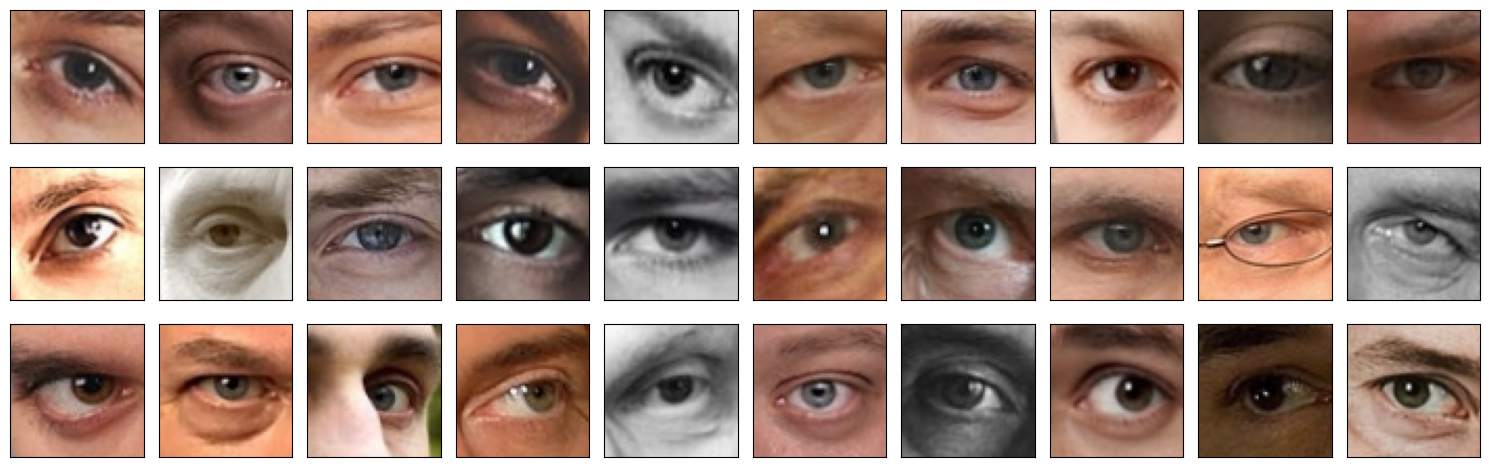

In [229]:
fig, axes = plt.subplots(3, 10, figsize=(15,5), dpi=100)
for i,ax in enumerate(axes.flat):
    img = df[df['label']==1].reset_index(drop=True).loc[i, 'image']
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Image size visualization

Most of the images are at size of 50 to 60. We need to resize it as a normalization step on image size.


In [7]:
df.groupby('shape').count()['image'].sort_values(ascending=False).head(20)

shape
(55, 55, 3)    564
(58, 58, 3)    555
(54, 54, 3)    555
(59, 59, 3)    554
(57, 57, 3)    530
(56, 56, 3)    529
(60, 60, 3)    500
(53, 53, 3)    495
(52, 52, 3)    462
(61, 61, 3)    435
(51, 51, 3)    405
(62, 62, 3)    393
(50, 50, 3)    366
(63, 63, 3)    342
(49, 49, 3)    305
(48, 48, 3)    285
(64, 64, 3)    285
(47, 47, 3)    236
(65, 65, 3)    226
(46, 46, 3)    209
Name: image, dtype: int64

<Axes: xlabel='w'>

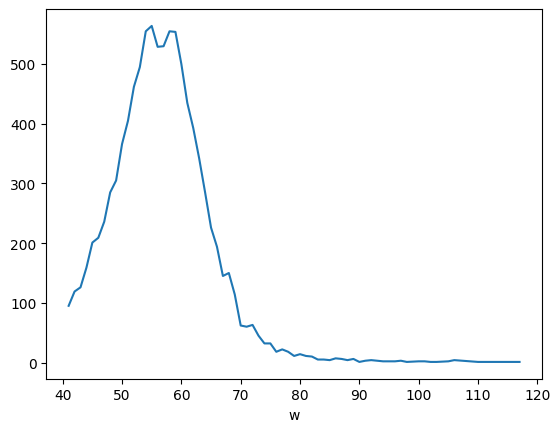

In [8]:
# plot distribution of image size
df.groupby('w').count()['image'].sort_index(ascending=False).plot()

<Axes: xlabel='w', ylabel='h'>

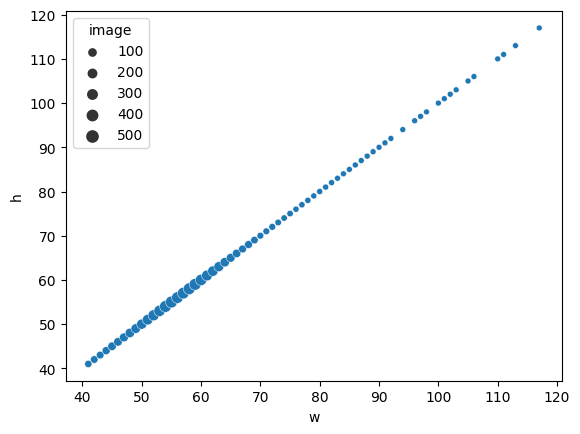

In [9]:
# display scatter, visualize the relationship between image w,h and it's scale
tmp_df = df.groupby(['w', 'h']).count()['image'].reset_index()
sns.scatterplot(data=tmp_df, x='w', y='h', size='image')

# Resize images

In [79]:
# resize all images into 64，64
df = pd.DataFrame(columns=['image', 'label'])
for label, gender in enumerate(['femaleeyes', 'maleeyes']):
    path = workspace + "/images/" + gender + "/*"
    files = glob.glob(path)
    print('file count: %d in workspace %s' % (len(files), path))
    for i, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.resize(img, (64, 64))
        if (i % 100 == 0):
            print("[%d/%d] %d %s" % (i, len(files), label, file))
        df.loc[df.index.size, 'image':'label'] = [img, label]

file count: 3678 in workspace /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/*
[0/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4481.jpg
[100/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4713.jpg
[200/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4373.jpg
[300/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5146.jpg
[400/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5108.jpg
[500/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/4949.jpg
[600/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 - Neural Network/project3/images/femaleeyes/5257.jpg
[700/3678] 0 /content/drive/My Drive/Colab Notebooks/AIDI 1009 -

# Dataset splitting

In [81]:
x_modeling, x_test, y_modeling, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=100)
x_train, x_val, y_train, y_val = train_test_split(x_modeling, y_modeling, test_size=0.25, random_state=100)

### Class scales

In [15]:
y_train.reset_index().groupby('label').count()

,index
label,
0,2227
1,3773


In [16]:
y_val.reset_index().groupby('label').count()

,index
label,
0,713
1,1287


In [17]:
y_test.reset_index().groupby('label').count()

,index
label,
0,738
1,1263


# KNN

In [107]:
x_train_flatten, x_val_flatten, x_test_flatten, y_train_flatten, y_val_flatten, y_test_flatten = [
    (lambda f: np.array([d if isinstance(d,int) else d.flatten() for d in f]))(xx) for xx in [x_train, x_val, x_test, y_train, y_val, y_test]]

x_train_flatten.shape, x_val_flatten.shape, x_test_flatten.shape, y_train_flatten.shape, y_val_flatten.shape, y_test_flatten.shape

((6000, 12288), (2000, 12288), (2001, 12288), (6000,), (2000,), (2001,))

In [116]:
err = []
for i in range(15):
    clf = KNeighborsClassifier(n_neighbors=i+1)
    clf.fit(x_train_flatten,y_train_flatten)
    pred = clf.predict(x_val_flatten)
    err.append(np.mean(pred != y_val_flatten))

Text(0.5, 1.0, 'elbow plot')

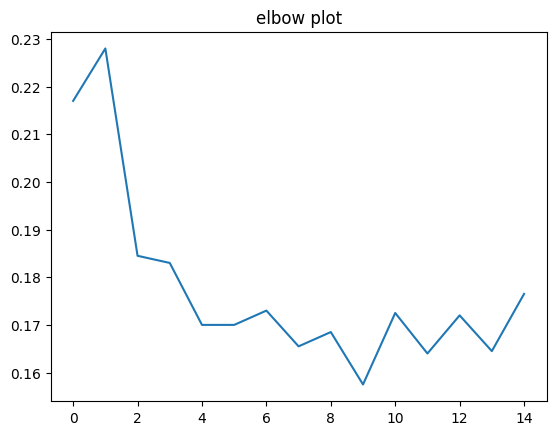

In [119]:
plt.figure()
plt.plot(range(15), err)
plt.title("elbow plot")

### Performance metrics (accuracy, precision, recall).

Get the best neightbour k from elbow plot.

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       738
           1       0.79      0.96      0.87      1263

    accuracy                           0.82      2001
   macro avg       0.84      0.76      0.78      2001
weighted avg       0.83      0.82      0.80      2001



Text(0.5, 1.0, 'Accuracy Score: 0.82')

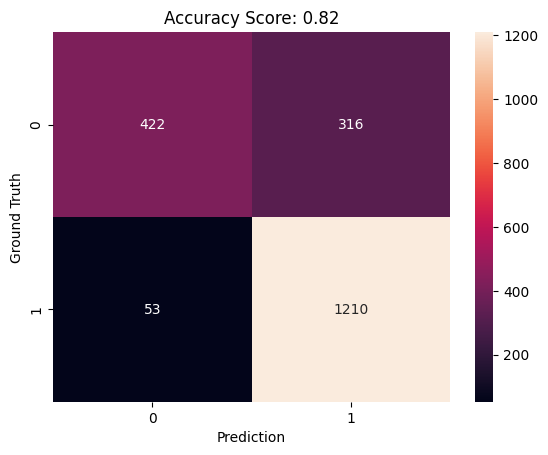

In [163]:
# use n=9 as KNN class number
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(x_train_flatten,y_train_flatten)
y_pred = clf.predict(x_test_flatten)

rc = recall_score(y_test_flatten, y_pred)
pr = precision_score(y_test_flatten, y_pred)
acc = accuracy_score(y_test_flatten, y_pred)
f1 = f1_score(y_test_flatten, y_pred)
roc = roc_auc_score(y_test_flatten, y_pred)
mat = confusion_matrix(y_test_flatten, y_pred)

reports = classification_report(y_test_flatten, y_pred)
print(reports)

plt.figure()
sns.heatmap(mat, annot=True, fmt='d')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Accuracy Score: %.2f' % (acc))

# MLP

As a binary classification problem, MLP abstract high level patterns from raw image training dataset. As a result, two hidden layers of a MLP will gain a good performance to abstract rich patterns to make a linear dicision.

In [167]:
image_shape=(64, 64, 3)
predict_classes = 1

from keras.activations import relu
from keras.optimizers import Adam


mlp_clf = Sequential([
    Dense(128, activation=relu), 
    Dropout(0.2),
    Dense(128, activation=relu), 
    Dropout(0.2),
    Dense(predict_classes, activation='sigmoid') 
])

mlp_clf.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [147]:
clf = mlp_clf.fit(StandardScaler().fit_transform(x_train_flatten), y_train_flatten, batch_size=256, 
                  validation_data=(x_val_flatten, y_val_flatten), epochs=20)

Epoch 1/20
24/24 [==============================] - 1s 17ms/step - loss: 0.6229 - accuracy: 0.6818 - val_loss: 58.9803 - val_accuracy: 0.4955
Epoch 2/20
24/24 [==============================] - 0s 14ms/step - loss: 0.5657 - accuracy: 0.7183 - val_loss: 18.6658 - val_accuracy: 0.7265
Epoch 3/20
24/24 [==============================] - 0s 13ms/step - loss: 0.5338 - accuracy: 0.7402 - val_loss: 5.3181 - val_accuracy: 0.7510
Epoch 4/20
24/24 [==============================] - 0s 13ms/step - loss: 0.4956 - accuracy: 0.7612 - val_loss: 2.8419 - val_accuracy: 0.7360
Epoch 5/20
24/24 [==============================] - 0s 14ms/step - loss: 0.4687 - accuracy: 0.7792 - val_loss: 1.8572 - val_accuracy: 0.7135
Epoch 6/20
24/24 [==============================] - 0s 14ms/step - loss: 0.4472 - accuracy: 0.7872 - val_loss: 3.3568 - val_accuracy: 0.7420
Epoch 7/20
24/24 [==============================] - 0s 14ms/step - loss: 0.4287 - accuracy: 0.7987 - val_loss: 34.1155 - val_accuracy: 0.7265
Epoch 8/20

### Predict with test data

In [148]:
y_pred = mlp_clf.predict(x_test_flatten)
y_pred

63/63 [==============================] - 0s 2ms/step


array([[0.6946017],
       [0.6946017],
       [1.       ],
       ...,
       [0.6946017],
       [1.       ],
       [1.       ]], dtype=float32)

In [149]:
y_pred_cls = [1 if y>0.5 else 0 for y in y_pred]

In [150]:
clf.history

{'loss': [0.6228903532028198,
  0.5657365918159485,
  0.5337570905685425,
  0.4955671429634094,
  0.46871545910835266,
  0.447184294462204,
  0.42866161465644836,
  0.421431303024292,
  0.40956825017929077,
  0.3903617858886719,
  0.36965182423591614,
  0.35694727301597595,
  0.32692161202430725,
  0.31266215443611145,
  0.30003082752227783,
  0.2932681739330292,
  0.28657957911491394,
  0.2928296625614166,
  0.2778959572315216,
  0.258473664522171],
 'accuracy': [0.6818333268165588,
  0.7183333039283752,
  0.7401666641235352,
  0.7611666917800903,
  0.7791666388511658,
  0.7871666550636292,
  0.7986666560173035,
  0.7986666560173035,
  0.8053333163261414,
  0.8236666917800903,
  0.8349999785423279,
  0.8364999890327454,
  0.8498333096504211,
  0.8601666688919067,
  0.8681666851043701,
  0.8686666488647461,
  0.875333309173584,
  0.8675000071525574,
  0.871999979019165,
  0.8816666603088379],
 'val_loss': [58.980289459228516,
  18.665834426879883,
  5.3180742263793945,
  2.841908216476

### Visualizing the testing results

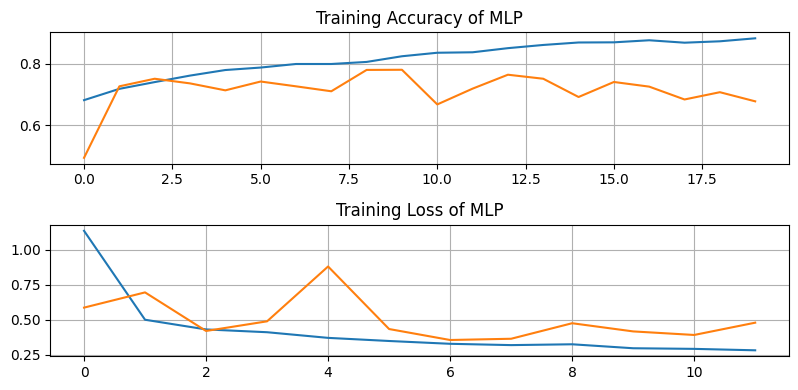

In [157]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), dpi=100)
sns.lineplot(data=clf.history['accuracy'], ax=axes[0])
sns.lineplot(data=clf.history['val_accuracy'], ax=axes[0])
axes[0].set_title('Training Accuracy of MLP')
axes[0].grid()
sns.lineplot(data=model2_history.history['loss'], ax=axes[1])
sns.lineplot(data=model2_history.history['val_loss'], ax=axes[1])
axes[1].set_title('Training Loss of MLP')
axes[1].grid()
plt.tight_layout()

### Performance metrics (accuracy, precision, recall).

63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.10      0.18       738
           1       0.65      0.99      0.79      1263

    accuracy                           0.67      2001
   macro avg       0.78      0.55      0.49      2001
weighted avg       0.75      0.67      0.57      2001



Text(0.5, 1.0, 'Accuracy Score: 0.67')

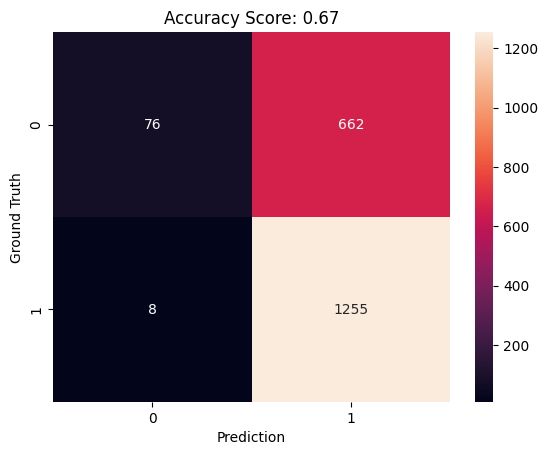

In [160]:
y_pred = mlp_clf.predict(x_test_flatten)
y_pred = [1 if y>0.5 else 0 for y in y_pred]
y_pred = np.round(y_pred)
rc = recall_score(y_test_flatten, y_pred)
pr = precision_score(y_test_flatten, y_pred)
acc = accuracy_score(y_test_flatten, y_pred)
f1 = f1_score(y_test_flatten, y_pred)
roc = roc_auc_score(y_test_flatten, y_pred)
mat = confusion_matrix(y_test_flatten, y_pred)

reports = classification_report(y_test_flatten, y_pred)
print(reports)

plt.figure()
sns.heatmap(mat, annot=True, fmt='d')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Accuracy Score: %.2f' % (acc))

# CNN

In [82]:
x_train_tensor, x_val_tensor, x_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = [
    (lambda x: tf.convert_to_tensor(np.stack(x.values)))(xx) for xx in [x_train, x_val, x_test, y_train, y_val, y_test]]
x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape, y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape 

(TensorShape([6000, 64, 64, 3]),
 TensorShape([2000, 64, 64, 3]),
 TensorShape([2001, 64, 64, 3]),
 TensorShape([6000]),
 TensorShape([2000]),
 TensorShape([2001]))

***
Convolution network learns shapes and patterns from its filters.

Filter depth k identifies how many patterns a filter could learn from scanning patches. Larger patch abstract pattern in a larger scale, smaller pathes abstract smaller patterens from its scanning. 

This is the reason why we design several convolution layers before full connection layers. We can learn multiple kinds of patterns with filter depth k, learn different pattern scales with different patch size. That's what we need from designing these convolution layers.

After these stages, we flatten the neurals as full connection layers, just like the MLP I implemented. Then a linear classifier is completed designed with this intuition.
***

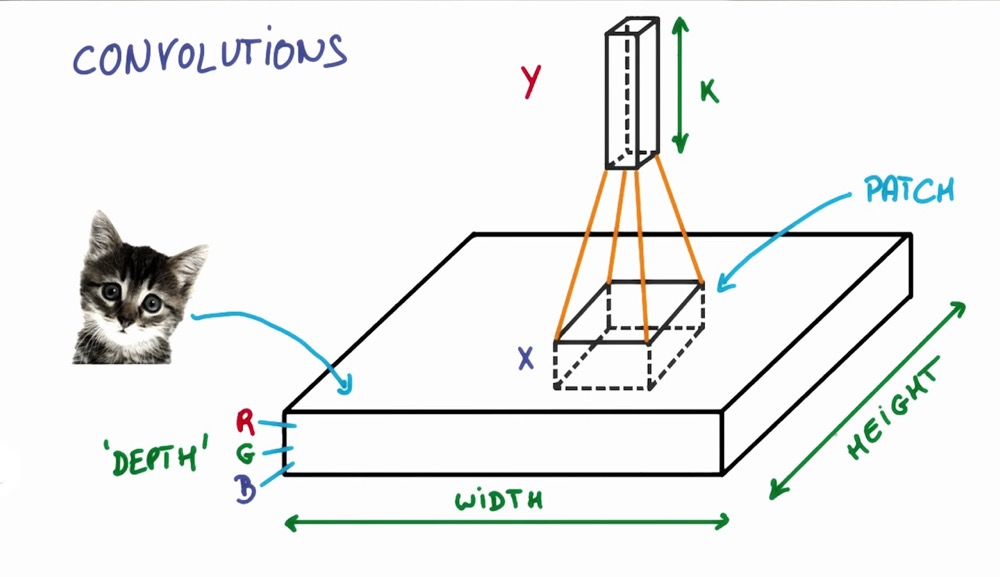

### CNN model 1

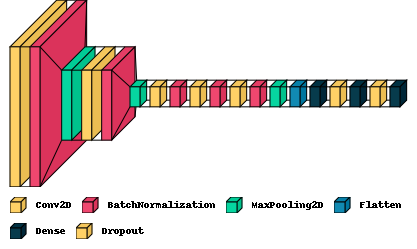

In [69]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, ZeroPadding2D, MaxPool2D
from keras.regularizers import l2

image_shape=(64, 64, 3)
predict_classes = 1
model1 = Sequential([
    # 1
    Conv2D(128, kernel_size=(13, 13), strides=(5, 5), activation='relu', input_shape=image_shape),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    # 2
    Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3)),

    # 3
    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    # 4
    Conv2D(256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    # 5
    Conv2D(256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    # 6
    Flatten(),
    Dense(1024, activation='relu'),
#     BatchNormalization(),
    Dropout(0.44),
    
    # 7
    Dense(1024, activation='relu'),
#     BatchNormalization(),
    Dropout(0.44),
    
    # 8
    Dense(predict_classes, activation='sigmoid'),
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(model1, scale_xy=10, scale_z=10, max_z=10, legend=True, spacing=10)

### CNN model 2 with L2 regularization = 0.02

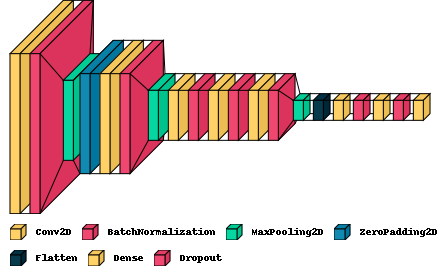

In [23]:
image_shape=(64, 64, 3)
predict_classes = 1

model2 = Sequential([
    # 1
    Conv2D(128, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=image_shape, 
           padding='same', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # 2
    ZeroPadding2D((1, 1)),
    Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # 3
#     ZeroPadding2D((1, 1)),
    Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
    BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),

    # 4
#     ZeroPadding2D((1, 1)),
    Conv2D(2048, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
    BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),

    # 5
#     ZeroPadding2D((1, 1)),
    Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # 6
    Flatten(),
    Dense(1024, activation='relu'),
#     BatchNormalization(),
    Dropout(0.3),

    # 7
    Dense(4096, activation='relu'),
#     BatchNormalization(),
    Dropout(0.3),

    # 8
    Dense(predict_classes, activation='sigmoid'),
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(model2, scale_xy=10, scale_z=10, max_z=10, legend=True, spacing=10)


### Early stop

Early stop is used when we don't have a confidence how many epochs we should use. As I used at here, if the training process didn't make any progress after 5 epochs, the training process will be stopped by this EarlyStopping() callback.

#### Training with CNN model 1

In [83]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', save_best_only=True)

model1_history = model1.fit(x_train_tensor, y_train_tensor, 
                            validation_data=(x_val_tensor, y_val_tensor), 
                            epochs=5000, verbose=1, callbacks=[es, mc])

Epoch 1/5000
188/188 [==============================] - 3s 15ms/step - loss: 0.0865 - accuracy: 0.9697 - val_loss: 0.2833 - val_accuracy: 0.9040
Epoch 2/5000
188/188 [==============================] - 3s 16ms/step - loss: 0.0803 - accuracy: 0.9747 - val_loss: 0.2653 - val_accuracy: 0.9140
Epoch 3/5000
188/188 [==============================] - 3s 16ms/step - loss: 0.0737 - accuracy: 0.9753 - val_loss: 0.2768 - val_accuracy: 0.9275
Epoch 4/5000
188/188 [==============================] - 2s 12ms/step - loss: 0.0590 - accuracy: 0.9788 - val_loss: 0.4201 - val_accuracy: 0.9200
Epoch 5/5000
188/188 [==============================] - 5s 24ms/step - loss: 0.0809 - accuracy: 0.9718 - val_loss: 0.4230 - val_accuracy: 0.8800
Epoch 6/5000
188/188 [==============================] - 2s 13ms/step - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.4351 - val_accuracy: 0.9205
Epoch 7/5000
188/188 [==============================] - 2s 11ms/step - loss: 0.0654 - accuracy: 0.9772 - val_loss: 0.3324 - val_ac

#### Training with CNN model 2

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)

model2_history = model2.fit(x_train_tensor, y_train_tensor, 
                            validation_data=(x_val_tensor, y_val_tensor), 
                            epochs=5000, verbose=1, callbacks=[es, mc])

Epoch 1/5000
188/188 [==============================] - 29s 110ms/step - loss: 1.1333 - accuracy: 0.6917 - val_loss: 0.5855 - val_accuracy: 0.7720
Epoch 2/5000
188/188 [==============================] - 18s 98ms/step - loss: 0.4991 - accuracy: 0.8237 - val_loss: 0.6941 - val_accuracy: 0.6450
Epoch 3/5000
188/188 [==============================] - 20s 105ms/step - loss: 0.4300 - accuracy: 0.8513 - val_loss: 0.4191 - val_accuracy: 0.8480
Epoch 4/5000
188/188 [==============================] - 19s 102ms/step - loss: 0.4101 - accuracy: 0.8542 - val_loss: 0.4879 - val_accuracy: 0.8220
Epoch 5/5000
188/188 [==============================] - 18s 94ms/step - loss: 0.3698 - accuracy: 0.8755 - val_loss: 0.8788 - val_accuracy: 0.5630
Epoch 6/5000
188/188 [==============================] - 18s 95ms/step - loss: 0.3476 - accuracy: 0.8818 - val_loss: 0.4328 - val_accuracy: 0.8330
Epoch 7/5000
188/188 [==============================] - 22s 116ms/step - loss: 0.3275 - accuracy: 0.8848 - val_loss: 0.35

### Training/Validating loss and accuracy

In [191]:
pd.DataFrame.from_dict(model1_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.086501,0.969667,0.283279,0.9040
1,0.080319,0.974667,0.265343,0.9140
2,0.073690,0.975333,0.276783,0.9275
3,0.059044,0.978833,0.420149,0.9200
4,0.080889,0.971833,0.422952,0.8800
5,0.050258,0.981500,0.435090,0.9205
6,0.065396,0.977167,0.332414,0.9255


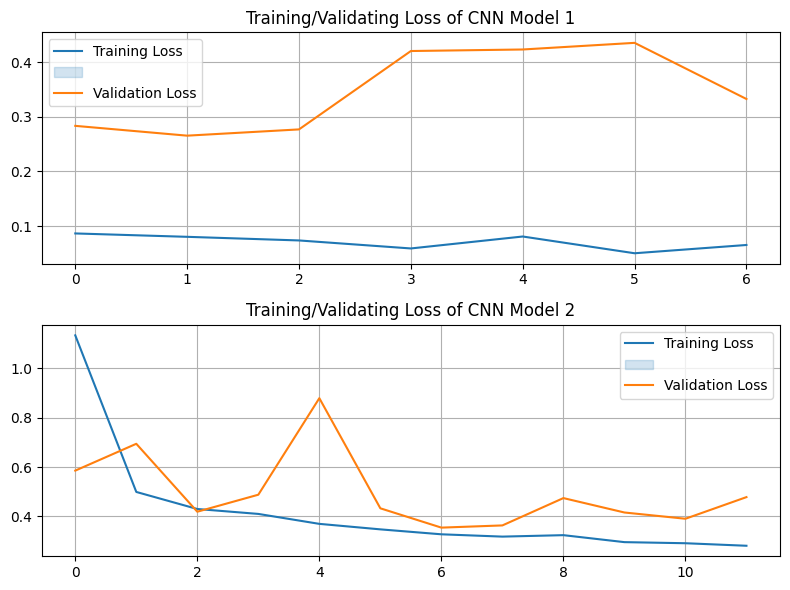

In [198]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=100)
axes.shape
sns.lineplot(data=model1_history.history['loss'], legend='brief', ax=axes[0])
sns.lineplot(data=model1_history.history['val_loss'], legend='brief', ax=axes[0])
axes[0].set_title('Training/Validating Loss of CNN Model 1')
axes[0].legend(['Training Loss', '', 'Validation Loss'])
axes[0].grid()
sns.lineplot(data=model2_history.history['loss'], ax=axes[1])
sns.lineplot(data=model2_history.history['val_loss'], ax=axes[1])
axes[1].set_title('Training/Validating Loss of CNN Model 2')
axes[1].legend(['Training Loss', '', 'Validation Loss'])
axes[1].grid()
plt.tight_layout()

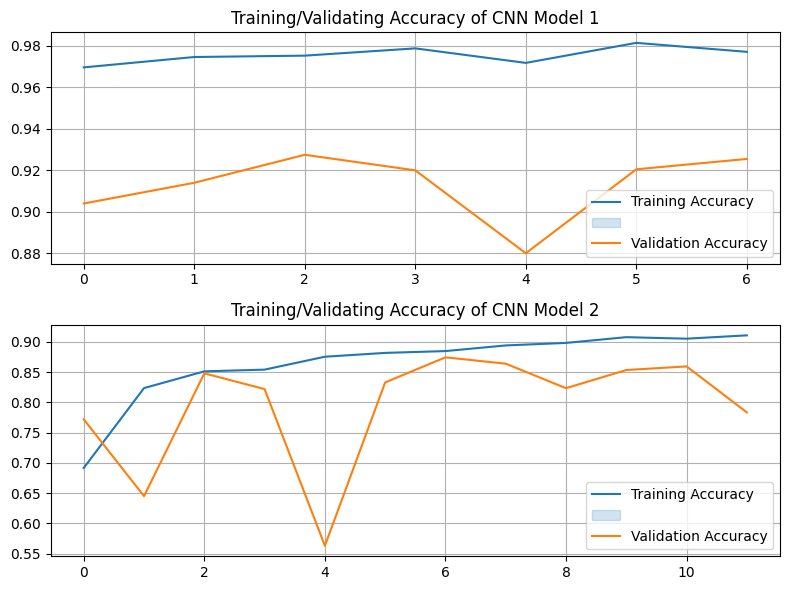

In [202]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=100)
sns.lineplot(data=model1_history.history['accuracy'], ax=axes[0])
sns.lineplot(data=model1_history.history['val_accuracy'], ax=axes[0])
axes[0].set_title('Training/Validating Accuracy of CNN Model 1')
axes[0].legend(['Training Accuracy', '', 'Validation Accuracy'])
axes[0].grid()
sns.lineplot(data=model2_history.history['accuracy'], ax=axes[1])
sns.lineplot(data=model2_history.history['val_accuracy'], ax=axes[1])
axes[1].set_title('Training/Validating Accuracy of CNN Model 2')
axes[1].legend(['Training Accuracy', '', 'Validation Accuracy'])
axes[1].grid()
plt.tight_layout()

### Performance metrics (accuracy, precision, recall).

63/63 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       738
           1       0.93      0.94      0.94      1263

    accuracy                           0.92      2001
   macro avg       0.92      0.91      0.92      2001
weighted avg       0.92      0.92      0.92      2001



Text(0.5, 1.0, 'Accuracy Score on CNN model 1: 0.92')

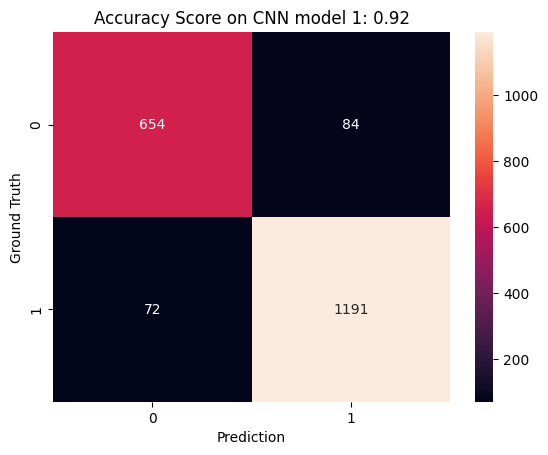

In [200]:
y_pred = model1.predict(x_test_tensor)
y_pred = np.round(y_pred)
rc = recall_score(y_test_tensor, y_pred)
pr = precision_score(y_test_tensor, y_pred)
acc = accuracy_score(y_test_tensor, y_pred)
f1 = f1_score(y_test_tensor, y_pred)
roc = roc_auc_score(y_test_tensor, y_pred)
mat = confusion_matrix(y_test_tensor, y_pred)

reports = classification_report(y_test_tensor, y_pred)
print(reports)

plt.figure()
sns.heatmap(mat, annot=True, fmt='d')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Accuracy Score on CNN model 1: %.2f' % (acc))

63/63 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.96      0.38      0.55       738
           1       0.73      0.99      0.84      1263

    accuracy                           0.77      2001
   macro avg       0.85      0.69      0.69      2001
weighted avg       0.82      0.77      0.73      2001



Text(0.5, 1.0, 'Accuracy Score on CNN model 2: 0.77')

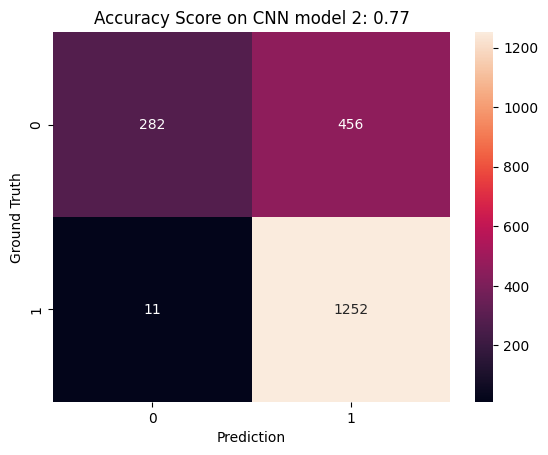

In [201]:
y_pred = model2.predict(x_test_tensor)
y_pred = np.round(y_pred)
rc = recall_score(y_test_tensor, y_pred)
pr = precision_score(y_test_tensor, y_pred)
acc = accuracy_score(y_test_tensor, y_pred)
f1 = f1_score(y_test_tensor, y_pred)
roc = roc_auc_score(y_test_tensor, y_pred)
mat = confusion_matrix(y_test_tensor, y_pred)

reports = classification_report(y_test_tensor, y_pred)
print(reports)

plt.figure()
sns.heatmap(mat, annot=True, fmt='d')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Accuracy Score on CNN model 2: %.2f' % (acc))

# Performance comparason

The performance of KNN is at accuracy of 82% as a baseline model. 

The accuracy of MLP is 67%. 

The accuracy of CNN model 1 is 92% while CNN model 2 is 77%.

# Conclusion

CNN is currently the standard reference for all image-related issues since it is so effective and strong. The key benefit of CNN over its rivals is that it automatically recognizes the crucial patterns without any human intervention, as opposed to categorising samples based only on their distance to one another. This makes the model which performs automatic feature extraction exceeded the achieve of human accuracy. And as compared to KNN and MLP, CNN outperforms the competition in terms of accuracy. 

Also, in comparison to MLP neural network, convolutional neural networks also reduce computation. It performs parameter sharing, specific convolution, and pooling procedures. This enables CNN to operate quickly and with great accuracy.